# Redes Neuronales - Trabajo Práctico N° 2 - Ejercicio 2
# Notebook #2: Regresión Lineal + Features Polinomiales

## Integrantes del grupo
* Gaytan, Joaquín Oscar
* Kammann, Lucas Agustín

### Fuentes

### Link: https://heartbeat.fritz.ai/5-regression-loss-functions-all-machine-learners-should-know-4fb140e9d4b0
En esta fuente se puede encontrar una breve explicación del MAE y del MSE, una comparación entre ambos respecto de su comportamiento en entrenamiento frente a conjuntos de datos con y sin outliers en el error de los resultados, y luego una comparación de su comportamiento durante entrenamiento a razón de cómo son sus gradientes, lo cual provoca en el caso del MAE que la convergencia sea más lenta y sea necesario utilizar un **learning rate dinámico**. Explica que, si nos importa que la presencia de outliers tenga un impacto directo sobre el modelo, deberíamos utilizar MSE, mientras que si deseamos que no afecte demasiado podemos emplear MAE.

### Link: https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1
En esta fuente se puede encontrar una explicación de los tres métodos para learning rate dinámico utilizados, el **time-based decay**, el **step decay** y el **exponential decay**, empleando para algunos de ellos la clase de Keras llamada Learning Rate Scheduler, que permite modificar a gusto del usuario el valor del learning rate a través del proceso.

### Link: https://stackoverflow.com/questions/46308374/what-is-validation-data-used-for-in-a-keras-sequential-model
Esta discusión de StackOverflow es interesante sobre la separación de los datasets en entrenamiento, validación y evaluación del modelo, la use para verificar algunas cuestiones sobre cómo usaba la información de validación Keras, entre otras cosas.

### Link: https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
Explicación sobre el uso de **early stopping**, donde básicamente buscamos parar el entrenamiento aunque no se hayan terminado de correr todos los epochs predefinidos, porque se detecta que no hay mejoría en los resultados obtenidos, para ello se emplea la métrica evaluada sobre el conjunto de validación.

### Link: https://machinelearningmastery.com/polynomial-features-transforms-for-machine-learning/
Explicación sobre el uso de **features polinomiales**, que básicamente consiste en agregar nuevas variables de entrada al modelo a partir de potencias obtenidas entre las variables de entrada originales. De esta forma, el espacio que conforman las variables es de mayor dimensión y por ello la solución es más flexible, aunque hay que tener cuidado de que no se ajuste demasiado provocando **overfitting**.

# 1. Cargando base de datos

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
import importlib

In [3]:
import sys

In [4]:
sys.path.insert(0, '../..')

In [5]:
# Read the database from the .csv file into a pandas dataframe
df = pd.read_csv('../../databases/insurance.csv')

# 2. Preprocesamiento de los datos

In [6]:
from sklearn import preprocessing

In [7]:
from src import helper
importlib.reload(helper);

## 2.1. Codificación de variables no numéricas

In [8]:
# Create a label encoder for the sex variable or feature and create a new column in the dataframe 
# with the encoded version of the gender
sex_encoder = preprocessing.LabelEncoder()
sex_encoder.fit(df['sex'])
df['sex-encoded'] = sex_encoder.transform(df['sex'])

In [9]:
# Create a label encoder for the smoker variable or feature and create a new column in the dataframe
# with the encoded version of the smoker
smoker_encoder = preprocessing.LabelEncoder()
smoker_encoder.fit(df['smoker'])
df['smoker-encoded'] = smoker_encoder.transform(df['smoker'])

In [10]:
# Create a one hot encoder and fit the available types of regions in the dataset
region_encoder = preprocessing.OneHotEncoder()
region_encoder.fit(df['region'].to_numpy().reshape(-1, 1))

# Transform all entries into the one hot encoded representation
encoded_regions = region_encoder.transform(df['region'].to_numpy().reshape(-1, 1)).toarray()

# Add each new encoded variable or feature to the dataset
for i, category in enumerate(region_encoder.categories_[0]):
    df[f'{category}-encoded'] = encoded_regions.transpose()[i]

## 2.2. Eliminando outliers
A partir del análisis realizado sobre la base de datos sobre la cual se entrenan los modelos, se detectaron outliers en la variable del índice de masa corporal, se decide remover estos datos por completo ya que no fue necesario tener en cuenta una estrategia para corregir datos incompletos o incorrectos y el impacto que tiene sobre la totalidad de datos es menos del 1%. Entonces, se eliminan los casos con outliers del BMI.

In [11]:
# Remove outliers by setting NaN on those rows at the column of BMI
helper.remove_outliers(df, 'bmi')

# Remove NaN values from the dataframe
df = df.dropna()

## 2.3. Filtrado de variables

In [12]:
# Filtering or removing of non desired variables
df_x = df[['age', 'bmi', 'smoker-encoded', 'children', 'sex-encoded', 'northwest-encoded', 'northeast-encoded', 'southwest-encoded', 'southeast-encoded']]
df_y = df['charges']

# 3. Separación del conjunto de entrenamiento y evaluación

In [13]:
from sklearn import model_selection

In [14]:
from sklearn import preprocessing

## 3.1. Separación de los conjuntos
Se realiza la separación del conjunto de datos original en **train**, **valid** y **test**.

In [15]:
# Split the dataset into train_valid and test
x_train_valid, x_test, y_train_valid, y_test = model_selection.train_test_split(df_x, df_y, test_size=0.2, random_state=5, shuffle=True)

In [16]:
# Split the dataset into train and valid
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_train_valid, y_train_valid, test_size=0.2, random_state=15, shuffle=True)

# 4. Regresión Lineal
En este punto, se comienzan las pruebas y experimentos de los modelos utilizados, con el objetivo de ganar intuición en los beneficios, mejores o desventajas en cómo se puedan modificar y agregar hiperparámetros. Las *observaciones y conclusiones* son comentarios de situaciones particulares que sucedieron o suceden en la última versión de los experimentos, a modo de reflexión y relevar las particularlidades más notables con las que nos fuimos encontrando.

#### Observaciones y conclusiones
1. Al principio, sucedió que el MAE era muy lento para convergencia, lo cual tiene sentido por cómo es su gradiente. Particularmente, comparado con MSE, es mucho más lento. Empezamos probando modificar de forma estática y a mano el **learning rate**.
2. Luego, con un learning rate cada vez mayor, pudimos observar que el entrenamiento era más rápido, pero sucedían dos cuestiones. En primer lugar, que se producía una especie oscilación en torno a un valor que asumo que es el mínimo al cual se acerca el entrenamiento, con lo cual sería necesario disminuir cerca de ahí el valor del learning rate. Por otro lado, este mínimo no era el mismo mínimo que obtuve con el MSE, debe ser un plateau, un mínimo local pero no el absoluto. Me propuse usar **learning rate dinámico** y **comenzar de diferentes puntos**.
3. Cuando probamos utilizar MSE, si no normalizaba con z-score todas las variables, rápidamente divergía la función de costo y se rompía el entrenamiento. Por otro lado, la misma normalización afectaba mucho al entrenamiento del MAE. *¿Por qué?* Lo pude corregir un poco al aumentar el learning rate por un factor, lo cual debe tener sentido si se considera que ahora las variables estando normalizadas tienen una menor magnitud lo cual puede producir que los pasos sean menores que antes, y por eso se ralentizó.
4. Interesante, encontramos esta discusión https://datascience.stackexchange.com/questions/9020/do-i-have-to-standardize-my-new-polynomial-features a raiz de una pregunta bastante sencilla, **¿por qué no está mejorando la métrica con mayor orden de polynomial features?**. Resulta ser que normalizando las variables y luego aplicando polynomial features, obtengo nuevas variables que siguen encontrándose en el intervalo [0,1] pero que su orden de magnitud es mucho menor. *Conclusión, siempre normalizar las variables que entran al modelo, y por ende si aplicas polynomial features tenés que normalizar luego de crear las nuevas variables.*
5. Con la corrección mencionada anteriormente con respecto a la normalización, mejoró el resultado de ordenes grandes de polinomios.
6. Nos llamó la atención que por lo general los resultados de validación eran mejores que en entrenamiento, y además, esta diferencia se achica más a medida que aumenta el orden de los polinomios. En este escenario, pensamos en dos posibilidades, un posible **underfitting** o bien un problema con los conjuntos de train, valid y test. No obstante, encontramos este artículo como una tercera opción que creemos que no aplica a nuestro problema. Este artículo menciona algo que puede ser útil https://keras.io/getting_started/faq/#why-is-my-training-loss-much-higher-than-my-testing-loss, una posibilidad sería que la validación sobre un epoch siempre tienda a ser mejor que el promedio del train en los batch, porque fue entrenándose mejor. Aunque no me convence después de muchos epochs que suceda esto. **¿Deberíamos estar usando k-folding?** **¿Deberíamos mejorar el modelo para no tener underfitting?**
7. Finalmente, se determinó que la baja cantidad de muestras en los datos provoca que los estimadores tengan una mayor varianza lo cual afecta drásticamente la estimación en la evaluación del modelo. En principio, se dejó utilizando el **método hold-out**, conscientes de que deberíamos aplicar **k-folding** para poder dar una estimación de menor varianza en el test.
8. En el conjunto de datos utilizados para **train**, **valid** y **test**, existen nueve **outliers** en el **BMI**, es menos de 1% del conjunto de datos pero antes no los estabamos removiendo, al quitarlos disminuyeron notoriamente las métricas de entrenamiento.

In [17]:
from src.ej2 import rl_helper
importlib.reload(rl_helper);

## 4.1. Experimentos, análisis y observaciones
En los experimentos a continuación se realizan diversas pruebas, y se van presentando comentarios y observaciones o conclusiones sobre los resultados. Vale mencionar, que en todos los escenarios se aplicó **early stop**, monitoreando el resultado de la función de costo sobre el conjunto de validación se busca parar el proceso de entrenamiento cuando no se detectan mejorías, para evitar tiempos de entrenamiento sin un resultado efectivo. Esto se acompaña con el uso de **model checkpoint**, así se registra el estado del modelo en el mejor resultado registrado, el cual se restaura al final del entrenamiento para evaluar los resultados efectivos.

In [18]:
# Create a list to hold the degree of the polynomial feature used and the performance in train and valid sets,
# elements should be of the format (degree, mae_train, mae_valid)
results = []

### 4.1.1. Regresión lineal
En estas primeras pruebas, se emplea una **regresión lineal** sin ninguna modificación, agregado, técnica o método especial. Es decir, se utiliza un modelo con una **capa densa de una única neurona o unidad**, que será la salida del modelo, con una función de activación **lineal** y una función de costo **MAE**. Por defecto, inicialmente se entrena utilizando como optimizador **SGD**.

#### Observaciones y conclusiones
Durante el entrenamiento del modelo, inicialmente la función de costo es muy elevada y además resulta un proceso muy lento, con lo cual la convergencia a una solución óptima requiere mucho tiempo. Esto se debe particularmente al uso del valor medio del error absoluto (**MAE**) como función de costo, cuya gradiente es menor que para otras funciones de costo como puede ser el caso del **MSE**.

In [19]:
# Run model experiment
mae_train, mae_valid, mae_test = rl_helper.run_model(x_train, y_train, x_valid, y_valid, x_test, y_test,
                                                     learning_rate=0.1,
                                                     decay_rate=0.01,
                                                     epochs=500,
                                                     batch_size=64,
                                                     tag='experiment-1'
                                                    )

# Register the results for the degree used
results.append([1, mae_train, mae_valid])

Model logs at tb-logs/rl/experiment-1/20210531-004409
Model checkpoints at checkpoints/rl/experiment-1/20210531-004409
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
[MAE] Train: 12513.67 Valid: 11605.37 Test: 13234.44


In [20]:
# Run model experiment
mae_train, mae_valid, mae_test = rl_helper.run_model(x_train, y_train, x_valid, y_valid, x_test, y_test,
                                                     learning_rate=1.0,
                                                     decay_rate=0.01,
                                                     epochs=500,
                                                     batch_size=64,
                                                     tag='experiment-2'
                                                    )

# Register the results for the degree used
results.append([1, mae_train, mae_valid])

Model logs at tb-logs/rl/experiment-2/20210531-004937
Model checkpoints at checkpoints/rl/experiment-2/20210531-004937
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
[MAE] Train: 7637.68 Valid: 6874.74 Test: 8443.88


### 4.1.2. Learning Rate Scheduling
Se busca solucionar la lenta convergencia que se tiene con una función de costo **MAE** al utilizar valores más grandes de **learning rate**, no obstante, es sabido que esto puede producir divergencia u oscilaciones indeseadas del modelo, entonces se propone probar diferentes esquemas dinámicos en donde el valor empleado puede evolucionar el tiempo, particularmente disminuyendo. Así, se empiezan con valores altos de learning rate que va decayendo con el tiempo, permitiendo alcanzar mínimos de forma más rapida y luego converger sin demasaidas oscilaciones.

#### Observaciones y conclusiones
Se puede notar una diferencia fuerte en la cantidad de tiempo requerido para entrenar el modelo, gracias al uso del **learning rate scheduling**. Además, eso permitió encontrar resultados mucho mejores. Particularmente, no se detectaron diferencias grandes en el resultado respecto del tipo de variación dinámica que se emplea. Se probó utilizar además el optimizador **adam** y el optimizador **RMSprop** y se vió que la curva de aprendizaje presentaba más variación en forma de picos y valles.

In [21]:
# Run model experiment
mae_train, mae_valid, mae_test = rl_helper.run_model(x_train, y_train, x_valid, y_valid, x_test, y_test,
                                                     learning_rate=1000,
                                                     scheduler='time-decay',
                                                     decay_rate=0.01,
                                                     epochs=500,
                                                     batch_size=64,
                                                     tag='experiment-3'
                                                    )

# Register the results for the degree used
results.append([1, mae_train, mae_valid])

Model logs at tb-logs/rl/experiment-3/20210531-005500
Model checkpoints at checkpoints/rl/experiment-3/20210531-005500
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
[MAE] Train: 3668.72 Valid: 3322.72 Test: 4478.52


In [22]:
# Run model experiment
mae_train, mae_valid, mae_test = rl_helper.run_model(x_train, y_train, x_valid, y_valid, x_test, y_test,
                                                     learning_rate=1.0,
                                                     scheduler='time-decay',
                                                     decay_rate=0.01,
                                                     epochs=500,
                                                     batch_size=64,
                                                     tag='experiment-4'
                                                    )

Model logs at tb-logs/rl/experiment-4/20210531-005701
Model checkpoints at checkpoints/rl/experiment-4/20210531-005701
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1)                 10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
[MAE] Train: 10865.36 Valid: 9963.14 Test: 11573.5


In [23]:
# Run model experiment
mae_train, mae_valid, mae_test = rl_helper.run_model(x_train, y_train, x_valid, y_valid, x_test, y_test,
                                                     learning_rate=1000,
                                                     scheduler='time-decay',
                                                     decay_rate=0.01,
                                                     optimizer='adam',
                                                     beta_1=0.9,
                                                     beta_2=0.99,
                                                     epochs=500,
                                                     batch_size=64,
                                                     tag='experiment-5'
                                                    )

Model logs at tb-logs/rl/experiment-5/20210531-010356
Model checkpoints at checkpoints/rl/experiment-5/20210531-010356
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1)                 10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
[MAE] Train: 3251.96 Valid: 3503.46 Test: 4244.9


In [24]:
# Run model experiment
mae_train, mae_valid, mae_test = rl_helper.run_model(x_train, y_train, x_valid, y_valid, x_test, y_test,
                                                     learning_rate=1000,
                                                     scheduler='step-decay',
                                                     drop_rate=0.5,
                                                     epochs_drop=10,
                                                     epochs=500,
                                                     batch_size=32,
                                                     tag='experiment-6'
                                                    )

Model logs at tb-logs/rl/experiment-6/20210531-010718
Model checkpoints at checkpoints/rl/experiment-6/20210531-010718
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1)                 10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
[MAE] Train: 3432.96 Valid: 3402.63 Test: 4363.57


In [25]:
# Run model experiment
mae_train, mae_valid, mae_test = rl_helper.run_model(x_train, y_train, x_valid, y_valid, x_test, y_test,
                                                     learning_rate=1000,
                                                     scheduler='step-decay',
                                                     drop_rate=0.5,
                                                     optimizer='adam',
                                                     beta_1=0.9,
                                                     beta_2=0.99,
                                                     epochs_drop=10,
                                                     epochs=500,
                                                     batch_size=32,
                                                     tag='experiment-7'
                                                    )

Model logs at tb-logs/rl/experiment-7/20210531-010925
Model checkpoints at checkpoints/rl/experiment-7/20210531-010925
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1)                 10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
[MAE] Train: 3219.83 Valid: 3516.67 Test: 4205.48


In [26]:
# Run model experiment
mae_train, mae_valid, mae_test = rl_helper.run_model(x_train, y_train, x_valid, y_valid, x_test, y_test,
                                                     learning_rate=1000,
                                                     scheduler='exponential-decay',
                                                     decay_rate=0.07,
                                                     epochs=500,
                                                     batch_size=32,
                                                     tag='experiment-8'
                                                    )

Model logs at tb-logs/rl/experiment-8/20210531-011105
Model checkpoints at checkpoints/rl/experiment-8/20210531-011105
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1)                 10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
[MAE] Train: 3737.59 Valid: 3352.02 Test: 4571.47


In [27]:
# Run model experiment
mae_train, mae_valid, mae_test = rl_helper.run_model(x_train, y_train, x_valid, y_valid, x_test, y_test,
                                                     learning_rate=1000,
                                                     scheduler='exponential-decay',
                                                     decay_rate=0.01,
                                                     optimizer='adam',
                                                     beta_1=0.9,
                                                     beta_2=0.99,
                                                     min_delta=5,
                                                     epochs=500,
                                                     batch_size=32,
                                                     tag='experiment-9'
                                                    )

Model logs at tb-logs/rl/experiment-9/20210531-011246
Model checkpoints at checkpoints/rl/experiment-9/20210531-011246
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1)                 10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
[MAE] Train: 3247.38 Valid: 3519.07 Test: 4276.44


In [28]:
# Run model experiment
mae_train, mae_valid, mae_test = rl_helper.run_model(x_train, y_train, x_valid, y_valid, x_test, y_test,
                                                     learning_rate=1000,
                                                     scheduler='exponential-decay',
                                                     decay_rate=0.01,
                                                     optimizer='rmsprop',
                                                     momentum=0.9,
                                                     rho=0.99,
                                                     min_delta=5,
                                                     epochs=500,
                                                     batch_size=32,
                                                     tag='experiment-9'
                                                    )

Model logs at tb-logs/rl/experiment-9/20210531-011433
Model checkpoints at checkpoints/rl/experiment-9/20210531-011433
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1)                 10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
[MAE] Train: 3265.79 Valid: 3502.68 Test: 4280.26


### 4.1.3. Polynomial Features
Es probable que la complejidad del modelo no sea lo suficientemente alta para poder representar correctamente la solución al problema, una posible solución es utilizar **polynomial features** que permite crear un espacio de soluciones más grande. A continuación, se prueba con diferentes órdenes y se observan resultados.

#### Observaciones y conclusiones
1. En general, los resultados son mucho mejores que con el escenario anterior de primer orden.
2. A medida que aumentamos el orden del feature polinomial, se observan pocas variaciones en la métrica de entrenamiento, pero se ve un incremento en la métrica de validación.
3. A medida que elevamos más el orden del feature polinomial, se puede observar que empiezan a suceder situaciones de **overfitting**, el modelo nuevamente pierde capacidad de generalización, pero esta vez porque su performance en entrenamiento da mucho mejor que en el resto de los casos. Esto evidencia que aprendió demasiado sobre entrenamiento. En este punto, deberíamos conseguir más datos para permitirle generalizar mejor, o limitar el gran espacio de soluciones que posee frente a la gran complejidad por ser de alto orden.
4. Observar que para ordenes muy grandes fue necesario reducir el batch size para poder encontrar una buena solución.
5. Observar que el learning rate empleado ahora es menor.
6. Observar que para el mayor órden la métrica se deterioró, puede ser que no haya un buen ajuste de hiperparámetros para alcanzar el mínimo, o también podría pasar que la información para obtener un buen resultado no es suficiente y faltan datos para entrenar un orden tan elevado.

In [29]:
# Run model experiment
mae_train, mae_valid, mae_test = rl_helper.run_model(x_train, y_train, x_valid, y_valid, x_test, y_test,
                                                     learning_rate=1000,
                                                     degree=2,
                                                     scheduler='exponential-decay',
                                                     decay_rate=0.09,
                                                     optimizer='adam',
                                                     beta_1=0.9,
                                                     beta_2=0.99,
                                                     patience=50,
                                                     min_delta=5,
                                                     epochs=1000,
                                                     batch_size=64,
                                                     tag='experiment-10'
                                                    )

# Register the results for the degree used
results.append([2, mae_train, mae_valid])

Model logs at tb-logs/rl/experiment-10/20210531-065653
Model checkpoints at checkpoints/rl/experiment-10/20210531-065653
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 1)                 55        
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________
[MAE] Train: 1784.37 Valid: 1959.21 Test: 2681.13


In [30]:
# Run model experiment
mae_train, mae_valid, mae_test = rl_helper.run_model(x_train, y_train, x_valid, y_valid, x_test, y_test,
                                                     learning_rate=1000,
                                                     degree=3,
                                                     scheduler='exponential-decay',
                                                     decay_rate=0.1,
                                                     optimizer='adam',
                                                     beta_1=0.9,
                                                     beta_2=0.99,
                                                     patience=50,
                                                     min_delta=5,
                                                     epochs=1000,
                                                     batch_size=64,
                                                     tag='experiment-11'
                                                    )

# Register the results for the degree used
results.append([3, mae_train, mae_valid])

Model logs at tb-logs/rl/experiment-11/20210531-070104
Model checkpoints at checkpoints/rl/experiment-11/20210531-070104
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 1)                 220       
Total params: 220
Trainable params: 220
Non-trainable params: 0
_________________________________________________________________
[MAE] Train: 1769.21 Valid: 2054.24 Test: 2831.25


In [31]:
# Run model experiment
mae_train, mae_valid, mae_test = rl_helper.run_model(x_train, y_train, x_valid, y_valid, x_test, y_test,
                                                     learning_rate=1000,
                                                     degree=4,
                                                     scheduler='exponential-decay',
                                                     decay_rate=0.1,
                                                     optimizer='adam',
                                                     beta_1=0.9,
                                                     beta_2=0.99,
                                                     patience=50,
                                                     min_delta=5,
                                                     epochs=1000,
                                                     batch_size=64,
                                                     tag='experiment-12'
                                                    )

# Register the results for the degree used
results.append([4, mae_train, mae_valid])

Model logs at tb-logs/rl/experiment-12/20210531-070520
Model checkpoints at checkpoints/rl/experiment-12/20210531-070520
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1)                 715       
Total params: 715
Trainable params: 715
Non-trainable params: 0
_________________________________________________________________
[MAE] Train: 1772.05 Valid: 2225.83 Test: 3007.08


In [32]:
# Run model experiment
mae_train, mae_valid, mae_test = rl_helper.run_model(x_train, y_train, x_valid, y_valid, x_test, y_test,
                                                     learning_rate=2.0,
                                                     degree=5,
                                                     scheduler='exponential-decay',
                                                     decay_rate=0.001,
                                                     optimizer='adam',
                                                     beta_1=0.9,
                                                     beta_2=0.99,
                                                     patience=50,
                                                     min_delta=5,
                                                     epochs=1000,
                                                     batch_size=64,
                                                     tag='experiment-13'
                                                    )

# Register the results for the degree used
results.append([5, mae_train, mae_valid])

Model logs at tb-logs/rl/experiment-13/20210531-070923
Model checkpoints at checkpoints/rl/experiment-13/20210531-070923
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 1)                 2002      
Total params: 2,002
Trainable params: 2,002
Non-trainable params: 0
_________________________________________________________________
[MAE] Train: 1727.61 Valid: 2005.75 Test: 2868.35


In [33]:
# Run model experiment
mae_train, mae_valid, mae_test = rl_helper.run_model(x_train, y_train, x_valid, y_valid, x_test, y_test,
                                                     learning_rate=5.0,
                                                     degree=6,
                                                     scheduler='exponential-decay',
                                                     decay_rate=0.01,
                                                     optimizer='adam',
                                                     beta_1=0.9,
                                                     beta_2=0.99,
                                                     patience=50,
                                                     min_delta=5,
                                                     epochs=1000,
                                                     batch_size=32,
                                                     tag='experiment-14'
                                                    )

# Register the results for the degree used
results.append([6, mae_train, mae_valid])

Model logs at tb-logs/rl/experiment-14/20210531-071855
Model checkpoints at checkpoints/rl/experiment-14/20210531-071855
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 1)                 5005      
Total params: 5,005
Trainable params: 5,005
Non-trainable params: 0
_________________________________________________________________
[MAE] Train: 1689.06 Valid: 2113.95 Test: 2956.51


In [34]:
# Run model experiment
mae_train, mae_valid, mae_test = rl_helper.run_model(x_train, y_train, x_valid, y_valid, x_test, y_test,
                                                     learning_rate=5.0,
                                                     degree=7,
                                                     scheduler='exponential-decay',
                                                     decay_rate=0.01,
                                                     optimizer='adam',
                                                     beta_1=0.9,
                                                     beta_2=0.99,
                                                     patience=50,
                                                     min_delta=5,
                                                     epochs=1000,
                                                     batch_size=32,
                                                     tag='experiment-15'
                                                    )

# Register the results for the degree used
results.append([7, mae_train, mae_valid])

Model logs at tb-logs/rl/experiment-15/20210531-072459
Model checkpoints at checkpoints/rl/experiment-15/20210531-072459
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 1)                 11440     
Total params: 11,440
Trainable params: 11,440
Non-trainable params: 0
_________________________________________________________________
[MAE] Train: 1621.28 Valid: 2152.73 Test: 3035.9


In [35]:
# Run model experiment
mae_train, mae_valid, mae_test = rl_helper.run_model(x_train, y_train, x_valid, y_valid, x_test, y_test,
                                                     learning_rate=5.0,
                                                     degree=8,
                                                     scheduler='exponential-decay',
                                                     decay_rate=0.01,
                                                     optimizer='adam',
                                                     beta_1=0.9,
                                                     beta_2=0.99,
                                                     patience=50,
                                                     min_delta=5,
                                                     epochs=1000,
                                                     batch_size=32,
                                                     tag='experiment-16'
                                                    )

# Register the results for the degree used
results.append([8, mae_train, mae_valid])

Model logs at tb-logs/rl/experiment-16/20210531-073103
Model checkpoints at checkpoints/rl/experiment-16/20210531-073103
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 1)                 24310     
Total params: 24,310
Trainable params: 24,310
Non-trainable params: 0
_________________________________________________________________
[MAE] Train: 1578.54 Valid: 2131.66 Test: 3295.88


In [36]:
# Run model experiment
mae_train, mae_valid, mae_test = rl_helper.run_model(x_train, y_train, x_valid, y_valid, x_test, y_test,
                                                     learning_rate=5.0,
                                                     degree=9,
                                                     scheduler='exponential-decay',
                                                     decay_rate=0.01,
                                                     optimizer='adam',
                                                     beta_1=0.9,
                                                     beta_2=0.99,
                                                     patience=50,
                                                     min_delta=5,
                                                     epochs=1000,
                                                     batch_size=32,
                                                     tag='experiment-17'
                                                    )

# Register the results for the degree used
results.append([9, mae_train, mae_valid])

Model logs at tb-logs/rl/experiment-17/20210531-073736
Model checkpoints at checkpoints/rl/experiment-17/20210531-073736
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 1)                 48620     
Total params: 48,620
Trainable params: 48,620
Non-trainable params: 0
_________________________________________________________________
[MAE] Train: 1535.92 Valid: 2131.7 Test: 3511.49


In [37]:
# Run model experiment
mae_train, mae_valid, mae_test = rl_helper.run_model(x_train, y_train, x_valid, y_valid, x_test, y_test,
                                                     learning_rate=5.0,
                                                     degree=10,
                                                     scheduler='exponential-decay',
                                                     decay_rate=0.001,
                                                     optimizer='adam',
                                                     beta_1=0.9,
                                                     beta_2=0.99,
                                                     patience=50,
                                                     min_delta=5,
                                                     epochs=1000,
                                                     batch_size=32,
                                                     tag='experiment-18'
                                                    )

# Register the results for the degree used
results.append([10, mae_train, mae_valid])

Model logs at tb-logs/rl/experiment-18/20210531-141804
Model checkpoints at checkpoints/rl/experiment-18/20210531-141804
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 1)                 92378     
Total params: 92,378
Trainable params: 92,378
Non-trainable params: 0
_________________________________________________________________
[MAE] Train: 5420.86 Valid: 5363.93 Test: 6841.81


#### Análisis de la métrica en función del orden de feature polinomial
Utilizando el registro de los resultados para cada orden de feature polinomial,se grafica la evolución para observar el comportamiento y sacar conclusiones a partir de ello.

In [38]:
import matplotlib.pyplot as plt

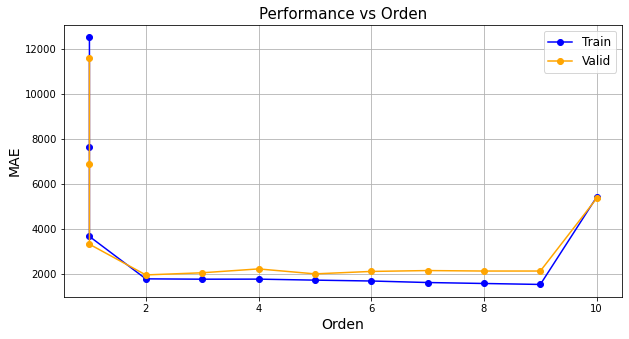

In [39]:
# Decoding results into its components
results_orders = [order for order, mae_train, mae_valid in results]
results_mae_train = [mae_train for order, mae_train, mae_valid in results]
results_mae_valid = [mae_valid for order, mae_train, mae_valid in results]

# Plot each of them with a color and a label
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(results_orders, results_mae_train, marker='o', color='blue', label='Train')
ax.plot(results_orders, results_mae_valid, marker='o', color='orange', label='Valid')
ax.set_xlabel('Orden', fontsize=14)
ax.set_ylabel('MAE', fontsize=14)
ax.set_title('Performance vs Orden', fontsize=15)
ax.legend(fontsize=12)
ax.grid()
plt.show()

### 4.1.3. Regularización
A partir de los resultados anteriores, se observa que a medida que aumentamos el orden del feature polinomial el modelo es capaz de resolver mejor el problema, no sólo mejorando la métrica, sino generalizando mejor. No obstante, cuando se eleva demasiado el orden del polinomio se empieza a enfrentar un problema de overfitting. Esto es, que el modelo presenta un espacio de soluciones de muy alta dimensionalidad que le permite adaptarse flexiblemente al comportamiento del conjunto de entrenamiento, entonces aunque esto no implique que la métrica de entrenamiento mejore, sí implica que la solución obtenida está muy arraigada a la naturaleza del conjunto de entrenamiento.
El objetivo ahora es emplear **regularización** para poder restringir el espacio de soluciones, utilizando los métodos **L1** y **L2**, para ver si se puede reducir el overfitting.

In [40]:
# Run model experiment
mae_train, mae_valid, mae_test = rl_helper.run_model(x_train, y_train, x_valid, y_valid, x_test, y_test,
                                                     learning_rate=1000.0,
                                                     degree=5,
                                                     regularizer='l2',
                                                     regularizer_lambda=6-4,
                                                     scheduler='exponential-decay',
                                                     decay_rate=0.09,
                                                     optimizer='adam',
                                                     beta_1=0.9,
                                                     beta_2=0.99,
                                                     patience=50,
                                                     min_delta=5,
                                                     epochs=1000,
                                                     batch_size=32,
                                                     tag='experiment-19'
                                                    )

Model logs at tb-logs/rl/experiment-19/20210531-142359
Model checkpoints at checkpoints/rl/experiment-19/20210531-142359
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 1)                 2002      
Total params: 2,002
Trainable params: 2,002
Non-trainable params: 0
_________________________________________________________________
[MAE] Train: 8334.6 Valid: 7604.0 Test: 8873.72


### 4.1.4. MSE (Mean Square Error) como función de costo
Por lo general, otra función de costo y métrica ampliamente utilizada en problemas de regresión es el **MSE**. Es sabido que la diferencia esencial entre las funciones de costo **MAE** y **MSE**, está en que cada una de ellas maximiza la verosimilitud del modelo con el conjunto de datos de entrenamiento, asumiendo que dada una colección de variables o features de entrada, la salida del modelo se comportará con una distribución de Laplace o Gaussiana respectivamente. Es decir, en **MAE** asumimos que la salida tendrá una distribución de Laplace y en **MSE** una distribución Gaussiana. La solución para cada caso será el punto de mayor probabilidad.

In [41]:
# Run model experiment
mae_train, mae_valid, mae_test = rl_helper.run_model(x_train, y_train, x_valid, y_valid, x_test, y_test,
                                                     learning_rate=1000,
                                                     degree=2,
                                                     scheduler='exponential-decay',
                                                     decay_rate=0.09,
                                                     loss='mse',
                                                     optimizer='adam',
                                                     beta_1=0.9,
                                                     beta_2=0.99,
                                                     patience=50,
                                                     min_delta=5,
                                                     epochs=1000,
                                                     batch_size=64,
                                                     tag='experiment-20'
                                                    )

# Register the results for the degree used
results.append([2, mae_train, mae_valid])

Model logs at tb-logs/rl/experiment-20/20210531-142655
Model checkpoints at checkpoints/rl/experiment-20/20210531-142655
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 1)                 55        
Total params: 55
Trainable params: 55
Non-trainable params: 0
_________________________________________________________________
[MAE] Train: 18820992.0 Valid: 23315550.0 Test: 35659096.0


### 4.2. Conclusiones
* La diferencia entre **MAE** y **MSE** desde la interpretación de cómo afectan al modelo, es que la penalización de un error es distinta a medida que es mayor. Esto provoca que en el MAE los errores sean tratados de igual forma, con lo cual el modelo tiende a solucionar el problema minimizando ese error que es más sencillo para los errores pequeños, dado que en los valores grandes se pueden encontrar outliers. Por otro lado, MSE da mayor peso o penalización a los pesos altos, esto fuerza al modelo a adaptarse para obtener una solución en donde se tengan en cuenta ampliamente los outliers. En conclusión, si se observan las predicciones de un modelo entrenado minimizando MAE y otro minimizando MSE, se verá esta clara distinción en cómo se distribuyen los errores. El MAE tenderá a tener error en los apartamientos más granes, el MSE tenderá a buscar un compromiso para incluir a los outliers, por lo cual su error tendrá una mayor distribución entre pequeños y grandes errores. **¡Importante! No ingorar**